# Evaluating ConcolicGrammarFuzzer

In this chapter, we will evaluate our concolic fuzzer that uses grammars. Namely, we want to compare  `ConcolicGrammarFuzzer` and `GrammarFuzzer`. We are mainly interested in **speed**, **line coverage**, **branch coverage** and **number of valid inputs** achieved by these fuzzers.

We will fuzz a simple Python program with both fuzzers and compare their success. Note that the features of `ConcolicGrammarFuzzer` is limited by symbolic execution and the SMT solver used ([Z3](https://github.com/Z3Prover/z3)), so we restricted our target to be a simple program. We believe this evaluation could be extended to more complex programs (which would lead to amore comprehensive evaluation of our concolic fuzzer) when more features are added to `ConcolicGrammarFuzzer` or Z3.

We describe our evaluation step by step, starting from the target program. We also describe our implementation of how we obtain our metrics (e.g. coverage) or how we run our fuzzers. Those who are interested only in the results can jump right in to [Evaluations](#evaluations) part. Note that it is very easy to replicate our evaluation. Furthermore, you can also try out the evaluation with different configurations.

### Table of Contents
1. [Target Program](#target-program)
2. [Calculating Coverage](#calculating-coverage)
3. [Representing Fuzzing Results](#representing-fuzzing-results)
4. [Running Fuzzers](#running-fuzzers)
5. [Comparing Fuzzing Results](#comparing-fuzzing-results)

Let's import our fuzzingbook utils and fuzzers first.

In [121]:
import fuzzingbook_utils

In [122]:
from ConcolicFuzzer import ConcolicGrammarFuzzer, ConcolicTracer
from GrammarFuzzer import GrammarFuzzer

## Target Program: `query_db` function <a name="target-program"></a>

Our target program, `query_db`, is a function defined as below. This simple function mimics querying an SQL database. We mock the SQL database using the `ConcolicDB` and its grammar `INVENTORY_GRAMMAR` from the [InformationFlow](InformationFlow.ipynb) chapter.

We should point some important aspects of `query_db`:
* The databese is initialized to `INITIAL_DB` in each execution. This is done mainly because we want the database to be in the same state for each query created by the fuzzers so that our results can be reproduced easily. Later on, we will also test our fuzzers with different `INITIAL_DB` values.


* If the query input is not valid, our target throws an `SQLException`. For example, if the table targeted by the query doesn't exist in the database, we would get an `SQLException`. This makes fuzzing challenging because fuzzers need to produce queries that have specific table or field names. Also, because of this, we expect the `ConcolicGrammarFuzzer` to be more successfull since it should be able to find out these specific values with symbolic execution and update its grammar to produce better queries.

In [118]:
from InformationFlow import INVENTORY_GRAMMAR, SQLException
from ConcolicFuzzer import ConcolicDB
from copy import deepcopy

INITIAL_DB = [
    (
        'vehicles',
        (
            {'year': int, 'kind': str, 'company': str, 'model': str},
            [
                {'year': 1997, 'kind': 'van', 'company': 'Ford', 'model': 'E350'},
                {'year': 2000, 'kind': 'car', 'company': 'Mercury', 'model': 'Cougar'},
                {'year': 1999, 'kind': 'car', 'company': 'Chevy', 'model': 'Venture'}
            ]
        )
    ),
    (
        'months',
        (
            {'month': int, 'name': str},
            [
                {'month': 1, 'name': 'jan'},
                {'month': 2, 'name': 'feb'},
                {'month': 3, 'name': 'mar'},
                {'month': 4, 'name': 'apr'},
                {'month': 5, 'name': 'may'},
                {'month': 6, 'name': 'jun'},
                {'month': 7, 'name': 'jul'},
                {'month': 8, 'name': 'aug'},
                {'month': 9, 'name': 'sep'},
                {'month': 10, 'name': 'oct'},
                {'month': 11, 'name': 'nov'},
                {'month': 12, 'name': 'dec'}
            ]
        )
    )
]

def query_db(query):
    global INITIAL_DB
    concolic_db = ConcolicDB()
    concolic_db.db = deepcopy(INITIAL_DB)
    return concolic_db.sql(query)

## Calculating Coverage: `FilteredCoverage` class <a name="calculating-coverage"></a>

We calculate the coverage achieved by the fuzzers with the context manager below (`FilteredCoverage`). This coverage class works very similar to `Coverage` and `BranchCoverage` classes which are described in the [Coverage](Coverage.ipynb) chapter. Further information about context managers can be found at [docs](https://docs.python.org/3/library/contextlib.html) and [PEP343](https://docs.python.org/3/whatsnew/2.6.html#pep-343-the-with-statement).

First, we should clarify why we chose to implement the `FilteredCoverage` class instead of using our already available `Coverage` and `BranchCoverage` classes. Main reason is that the execution of the target program is wrapped by concolic execution in `ConcolicGrammarFuzzer`. Instances of many types (`int`, `str`, `float` etc.) are replaced by their symbolic equivalents (`zint`, `zstr`, `zfloat` etc.) and during the execution, methods of these symbolic types are called frequently. However, we are not interested in these methods since they are not related to the target program. In other words, if we were to use `Coverage` or `BranchCoverage` class, we would obtain coverages from many functions which are not related to target program but to our concolic execution implementation.

In order to avoid this, we chose to whitelist the functions that we are interested in. The `FilteredCoverage` class takes a set of function names and traces only the functions included in this set, obtaining their line/branch coverage. In other words, it provides a filtered coverage (hence the name) which includes only the functions we whitelist. Also, note that `FilteredCoverage` provides both line coverage and branch coverage.

Another option is to blacklist the functions that we are not interested in. However, this also requires to blacklist all the functions used in concolic execution, which could be cumbersome because of the third-party software components used (e.g. Z3). Thus, for simplicity, we chose whitelisting.

You don't need to understand fully how the following works, but if you are interested in, we encourage you to check out the [Coverage](Coverage.ipynb) chapter.

In [123]:
import sys

class FilteredCoverage:
    def __init__(self, functions=set()):
        self._traces = []
        self._line_coverage = set()
        self._branch_coverage = set()
        self._functions = functions
    
    def __enter__(self):
        self.original_tracer = sys.gettrace()
        sys.settrace(self._tracer)
        return self

    def __exit__(self, exc_type, exc_value, tb):
        sys.settrace(self.original_tracer)
        
    def _tracer(self, frame, event, arg):
        if self.original_tracer is not None:
            self.original_tracer(frame, event, arg)
            
        should_trace = (event == 'line' and 
                        frame.f_code.co_name in self._functions)
        
        if should_trace:
            function_name = frame.f_code.co_name
            line_no = frame.f_lineno
            trace = (function_name, line_no)
            
            if len(self._traces) > 0:
                last_trace = self._traces[-1]
                if last_trace[0] == function_name:
                    self._branch_coverage.add((last_trace, trace))
                
            self._traces.append(trace)
            self._line_coverage.add(trace)

        return self._tracer
    
    def get_traces(self):
        return self._traces

    def get_line_coverage(self):
        return self._line_coverage
    
    def get_branch_coverage(self):
        return self._branch_coverage

Here is how this class can be used.

In [181]:
def my_multiply(n1, n2):
    r = n1 * n2
    return r

def my_square(n):
    r = my_multiply(n, n)
    return r

In [182]:
functions = {'my_multiply', 'my_square'}
with FilteredCoverage(functions) as fc:
    my_square(3)

print(fc.get_line_coverage())
print(fc.get_branch_coverage())

{('my_square', 6), ('my_square', 7), ('my_multiply', 2), ('my_multiply', 3)}
{(('my_multiply', 2), ('my_multiply', 3))}


Let's try obtaining coverage only from `my_multiply` function.

In [183]:
functions = {'my_multiply'}
with FilteredCoverage(functions) as fc:
    my_square(3)

print(fc.get_line_coverage())
print(fc.get_branch_coverage())

{('my_multiply', 2), ('my_multiply', 3)}
{(('my_multiply', 2), ('my_multiply', 3))}


## Representing Fuzzing Results: `Result` class <a name="representing-fuzzing-results"></a>

We will obtain many metrics (line coverage, branch coverage, expeptions raised ...) when we fuzz our target program. To easily represent and compare these with other fuzzer's results, we define a class called `Result`. It contains all the metrics we are interested in. For convenience, each fuzzer runner will return a `Result` object.

Implementation is fairly simple and self-explanatory. Nevertheless, here are some basic explanations for constructor parameters and metrics provided as class fields.

Constructor takes these parameters:
* **functions**: set of function names that we want to obtain coverage from
* **fuzzer_name**: name of the fuzzer
* **n_fuzz**: number of fuzzes
* **line_coverage**: set of `(function_name, line_no)` tuples, represents total line coverage
* **branch_coverage**: set of `((function_name, line_no1), (function_name, line_no2))` tuples, represents total branch coverage
* **exceptions**:  exceptions thrown while fuzzing
* **valid_inputs**:  inputs produced by fuzzer which did not result in an exception
* **elapsed_time**:  seconds it took to fuzz n_fuzz times

Main metric fields (remaining fields are self-explanatory):
* **line_coverage_dict**: lines covered of each function, function_name -> list_lines_covered
* **branch_coverage_dict**: branches covered of each function, function_name -> list_branches_covered
* **exceptions_dict**: exceptions raised of each type, exception_type -> list_exceptions


In [124]:
from collections import defaultdict

class Result:
    def __init__(
            self, 
            functions,
            fuzzer_name,
            n_fuzz,
            line_coverage, 
            branch_coverage, 
            exceptions, 
            valid_inputs,
            elapsed_time):
        
        self.functions = functions
        self.fuzzer_name = fuzzer_name
        self.n_fuzz = n_fuzz
        
        self.line_coverage = line_coverage
        self.branch_coverage = branch_coverage
    
        self.exceptions = exceptions
        self.valid_inputs = valid_inputs
        
        self.n_lines_covered = len(line_coverage)
        self.n_branches_covered = len(branch_coverage)
        self.n_exceptions = len(exceptions)
        self.n_valid_inputs = len(valid_inputs)
        self.valid_input_percentage = (len(valid_inputs) / float(n_fuzz)) * 100
        
        self.elapsed_time = elapsed_time
        
        self.line_coverage_dict = self._generate_line_coverage_dict()
        self.branch_coverage_dict = self._generate_branch_coverage_dict()
        self.exceptions_dict = self._generate_exceptions_dict()

    def _generate_line_coverage_dict(self):
        line_coverage_dict = defaultdict(list)
        for function_name, line in self.line_coverage:
            line_coverage_dict[function_name].append(line)
        return line_coverage_dict

    def _generate_branch_coverage_dict(self):
        branch_coverage_dict = defaultdict(list)
        for branch in self.branch_coverage:
            function_name = branch[0][0]
            branch_coverage_dict[function_name].append(branch)
        return branch_coverage_dict
            
    def _generate_exceptions_dict(self):
        exceptions_dict = defaultdict(list)
        for e in self.exceptions:
            e_type = type(e).__name__
            exceptions_dict[e_type].append(e)
        return exceptions_dict

Now, we will see how this class is used in fuzzer runners.

## Running Fuzzers: `run_concolic_fuzzer` and `run_concolic_grammar_fuzzer` <a name="running-fuzzers"></a>

A single function that fuzzes a given target multiple times using a given fuzzer object would be pretty useful. For this purpose, we implement the `fuzz_multiple_times` function, which takes a target, set of functions to obtain coverage from, a fuzzer instance, and number of fuzzes. This function not only fuzzes the target, but also saves line coverage, branch coverage, exceptions, valid inputs, elapsed time, and returns a `Result` object with these metrics.

**A tiny implementation detail - `run_target`**: Note that while fuzzing with `ConcolicGrammarFuzzer`, we need to do some extra work compared to `GrammarFuzzer`. Namely, we need to invoke the target program in the context of `ConcolicTracer` (thus, we have concolic execution) and update the grammar in `ConcolicGrammarFuzzer` after each concolic invocation. Because of this, we also implement the inner function `run_target` which runs the target program properly according the fuzzer's type.

In [159]:
import time

def fuzz_multiple_times(target, functions, fuzzer, n_fuzz):
    fuzzer_name = fuzzer.__class__.__name__
    
    def run_target(inp):
        if 'concolic' in fuzzer_name.lower():
            with ConcolicTracer() as tracer:
                try:
                    return tracer[target](inp)
                except Exception as e:
                    raise e
                finally:
                    fuzzer.update_grammar(tracer)
        else:
            return target(inp)
    
    line_coverage = set()
    branch_coverage = set()
    exceptions = []
    valid_inputs = []
    
    start_time = time.time()

    for i in range(n_fuzz):
        print('{0:<30}-> fuzz {1} of {2}'.format(fuzzer_name, i, n_fuzz), end='\r')
        inp = fuzzer.fuzz()
        with FilteredCoverage(functions) as fc:
            try:
                run_target(inp)
                valid_inputs.append(inp)
            except Exception as e:
                exceptions.append(e)

        line_coverage |= fc.get_line_coverage()
        branch_coverage |= fc.get_branch_coverage()
        
    elapsed_time = time.time() - start_time

    print('{0:<30}-> fuzzed {1} times in {2:.2f} seconds!'.format(fuzzer_name, n_fuzz, elapsed_time))
    
    return Result(functions,
                  fuzzer_name,
                  n_fuzz,
                  line_coverage, 
                  branch_coverage, 
                  exceptions,
                  valid_inputs,
                  elapsed_time)

Now that we have our "generic" function to run our fuzzer instances of different types, let's continue with runners of each fuzzer, `run_grammar_fuzzer` and `run_concolic_grammar_fuzzer`. These are very simple functions which instantiate a fuzzer with the given configurations and fuzz the target many times with the help of `fuzz_multiple_times`. When the fuzzing is all done, these runners return a `Result` object which contains all the metrics we are interested in.

In [160]:
def run_grammar_fuzzer(
        target, 
        grammar, 
        max_nonterminals,
        n_fuzz,
        functions): 
    
    gf = GrammarFuzzer(grammar=grammar, 
                       max_nonterminals=max_nonterminals)
    
    result = fuzz_multiple_times(target=target, 
                                 functions=functions, 
                                 fuzzer=gf, 
                                 n_fuzz=n_fuzz)
    
    return result

In [161]:
def run_concolic_grammar_fuzzer(
        target, 
        grammar, 
        max_nonterminals, 
        n_fuzz,
        functions):
    
    cgf = ConcolicGrammarFuzzer(grammar=grammar,
                                max_nonterminals=max_nonterminals)

    #tokens_to_prune = ['<value>', '<table>', '<column>', 
    #                   '<literals>', '<exprs>', '<bexpr>'] 
    
    tokens_to_prune = [] 
    
    cgf.prune_tokens(tokens_to_prune)
    
    result = fuzz_multiple_times(target=target, 
                                 functions=functions, 
                                 fuzzer=cgf, 
                                 n_fuzz=n_fuzz)
    
    return result

Soon we will run our fuzzers and compare their results, all we need is just a little patience!

Or you can jump right into [Evaluations](#evaluations).

## Comparing Fuzzing Results: `ResultComparator` class <a name="comparing-fuzzing-results"></a>

In [157]:
import matplotlib.pyplot as plt
import numpy as np

class ResultComparator:
    def __init__(self, result1, result2):
        self.result1 = result1
        self.result2 = result2
        
        self.name1 = result1.fuzzer_name
        self.name2 = result2.fuzzer_name
        
        assert(result1.functions == result2.functions)
        self.functions = result1.functions
 
    def _print_formatted(self, arg1, arg2, arg3):
        print('{0: <30} {1: <25} {2: <25}'.format(arg1, arg2, arg3))
        
    def _print_title(self, title):
        print('\n')
        self._print_formatted(title, self.name1, self.name2)
        print('-' * 80)
        
    def _print_coverage_comparison(self, cov_dict1, n1, cov_dict2, n2, title):
        self._print_title(title)
        self._print_formatted('all functions', n1, n2)
        for f in self.functions:
            n_lines1 = len(cov_dict1[f])
            n_lines2 = len(cov_dict2[f])
            self._print_formatted(f, n_lines1, n_lines2)
    
    def _plot_coverage_comparison(self, cov_dict1, n1, cov_dict2, n2, title):
        x_indexes = [i for i in range(len(self.functions) + 1)]
        x_labels = ['all functions'] + list(self.functions)

        plt.title(title)
        plt.bar([x-0.1 for x in x_indexes], 
                [n1] + [len(cov_dict1[f]) for f in self.functions],  
                width=0.2, align='center', label=self.name1)

        plt.bar([x+0.1 for x in x_indexes], 
                [n2] + [len(cov_dict2[f]) for f in self.functions],  
                width=0.2, align='center', label=self.name2)

        plt.legend(loc='upper right')
        plt.xticks(x_indexes, x_labels, rotation=20)
        plt.show()
        
    def compare_line_coverage(self):
        args = [
            self.result1.line_coverage_dict,
            self.result1.n_lines_covered,
            self.result2.line_coverage_dict,
            self.result2.n_lines_covered,
            'Line Coverage'
        ]
        
        self._print_coverage_comparison(*args)
        self._plot_coverage_comparison(*args)
    
    def compare_branch_coverage(self):
        args = [
            self.result1.branch_coverage_dict,
            self.result1.n_branches_covered,
            self.result2.branch_coverage_dict,
            self.result2.n_branches_covered,
            'Branch Coverage'
        ]
        
        self._print_coverage_comparison(*args)
        self._plot_coverage_comparison(*args)
    
    def compare_exceptions(self):
        n_all1 = self.result1.n_exceptions
        n_all2 = self.result2.n_exceptions

        e_dict1 = self.result1.exceptions_dict
        e_dict2 = self.result2.exceptions_dict

        self._print_title('Exception Type')
        self._print_formatted('all exceptions', n_all1, n_all2)
        
        all_e_types = e_dict1.keys() | e_dict2.keys()
        for e_type in all_e_types:
            n1 = len(e_dict1[e_type])
            n2 = len(e_dict2[e_type])
            self._print_formatted(e_type, n1, n2)

    def compare_valid_inputs(self):
        n1 = self.result1.n_valid_inputs
        n2 = self.result2.n_valid_inputs
        
        perc1 = self.result1.valid_input_percentage
        perc2 = self.result2.valid_input_percentage

        self._print_title('Valid Inputs')
        self._print_formatted('Number', n1, n2)
        self._print_formatted('Percentage %', perc1, perc2)

    def compare_elapsed_time(self):
        t1_ms = '{:.0f} ms'.format(self.result1.elapsed_time * 1000)
        t2_ms = '{:.0f} ms'.format(self.result2.elapsed_time * 1000)
        
        t1_s = '{:.2f} s'.format(self.result1.elapsed_time)
        t2_s = '{:.2f} s'.format(self.result2.elapsed_time)
        
        t1_m = '{:.2f} m'.format(self.result1.elapsed_time / 60.0)
        t2_m = '{:.2f} m'.format(self.result2.elapsed_time / 60.0)
        
        self._print_title('Elapsed Time')
        self._print_formatted('in minutes', t1_m, t2_m)
        self._print_formatted('in seconds', t1_s, t2_s)
        self._print_formatted('in milliseconds', t1_ms, t2_ms)

    def compare_all(self):
        self.compare_line_coverage()
        self.compare_branch_coverage()
        self.compare_exceptions()
        self.compare_valid_inputs()
        self.compare_elapsed_time()

## Fuzzing Configuration

In [162]:
N_FUZZ_DEFAULT = 10
TARGET_DEFAULT = query_db
GRAMMAR_DEFAULT = INVENTORY_GRAMMAR
MAX_NONTERMINALS_DEFAULT = 10
FUNCTIONS_DEFAULT = {
    'sql', 
    'table',
    'do_update', 
    'do_insert', 
    'do_delete', 
    'query_db'
}

## Evaluations <a name="evaluations"></a>

## Comparative Run

In [163]:
def comperative_run(runner1, config1, runner2, config2):
    result1 = runner1(**config1)
    result2 = runner2(**config2)
    return result1, result2

In [164]:
def compare_results(result1, result2):
    result_comparator = ResultComparator(result1, result2)    
    result_comparator.compare_all()

ConcolicGrammarFuzzer         -> fuzzed 10000 times in 1186.39 seconds!
GrammarFuzzer                 -> fuzzed 10000 times in 277.66 seconds!


Line Coverage                  ConcolicGrammarFuzzer     GrammarFuzzer            
--------------------------------------------------------------------------------
all functions                  61                        29                       
query_db                       3                         3                        
do_delete                      11                        5                        
do_insert                      15                        5                        
do_update                      21                        6                        
table                          4                         3                        
sql                            7                         7                        


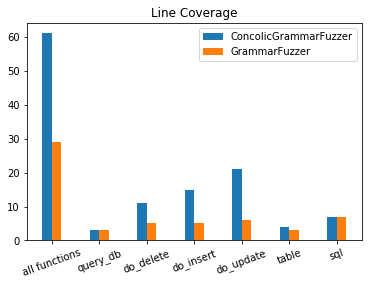



Branch Coverage                ConcolicGrammarFuzzer     GrammarFuzzer            
--------------------------------------------------------------------------------
all functions                  57                        25                       
query_db                       2                         2                        
do_delete                      10                        4                        
do_insert                      14                        4                        
do_update                      20                        5                        
table                          4                         3                        
sql                            7                         7                        


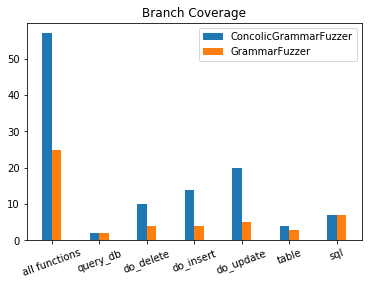



Exception Type                 ConcolicGrammarFuzzer     GrammarFuzzer            
--------------------------------------------------------------------------------
SQLException                   9384                      10000                    
TypeError                      338                       0                        


Valid Inputs                   ConcolicGrammarFuzzer     GrammarFuzzer            
--------------------------------------------------------------------------------
Number                         278                       0                        
Percentage                     2.78                      0.0                      


Elapsed Time                   ConcolicGrammarFuzzer     GrammarFuzzer            
--------------------------------------------------------------------------------
In minutes                     19.77 m                   4.63 m                   
In seconds                     1186.39 s                 277.66 s                 
In m

In [165]:
config = {
    'target': TARGET_DEFAULT, 
    'grammar': GRAMMAR_DEFAULT, 
    'max_nonterminals': MAX_NONTERMINALS_DEFAULT, 
    'n_fuzz': 10000,
    'functions': FUNCTIONS_DEFAULT
}

result1, result2 = comperative_run(
    runner1=run_concolic_grammar_fuzzer,
    config1=config,
    runner2=run_grammar_fuzzer,
    config2=config
)

compare_results(result1, result2)

ConcolicGrammarFuzzer         -> fuzzed 1000 times in 120.74 seconds!
GrammarFuzzer                 -> fuzzed 1000 times in 28.17 seconds!


Line Coverage                  ConcolicGrammarFuzzer     GrammarFuzzer            
--------------------------------------------------------------------------------
all functions                  61                        29                       
query_db                       3                         3                        
do_delete                      11                        5                        
do_insert                      15                        5                        
do_update                      21                        6                        
table                          4                         3                        
sql                            7                         7                        


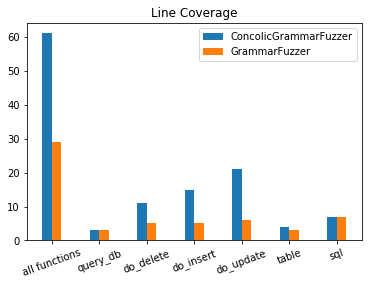



Branch Coverage                ConcolicGrammarFuzzer     GrammarFuzzer            
--------------------------------------------------------------------------------
all functions                  57                        25                       
query_db                       2                         2                        
do_delete                      10                        4                        
do_insert                      14                        4                        
do_update                      20                        5                        
table                          4                         3                        
sql                            7                         7                        


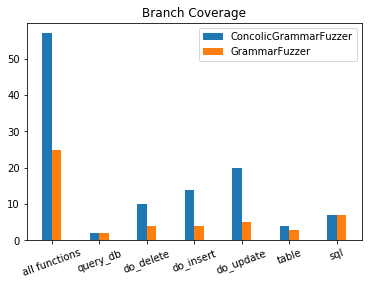



Exception Type                 ConcolicGrammarFuzzer     GrammarFuzzer            
--------------------------------------------------------------------------------
SQLException                   925                       1000                     
TypeError                      42                        0                        


Number of Valid Inputs         ConcolicGrammarFuzzer     GrammarFuzzer            
--------------------------------------------------------------------------------
                               33                        0                        


Elapsed Time                   ConcolicGrammarFuzzer     GrammarFuzzer            
--------------------------------------------------------------------------------
In minutes                     2.01 m                    0.47 m                   
In seconds                     120.74 s                  28.17 s                  
In milliseconds                120736 ms                 28166 ms                 


In [115]:
config = {
    'target': TARGET_DEFAULT, 
    'grammar': GRAMMAR_DEFAULT, 
    'max_nonterminals': MAX_NONTERMINALS_DEFAULT, 
    'n_fuzz': 1000,
    'functions': FUNCTIONS_DEFAULT
}

result1, result2 = comperative_run(
    runner1=run_concolic_grammar_fuzzer,
    config1=config,
    runner2=run_grammar_fuzzer,
    config2=config
)

compare_results(result1, result2)

## under construction

In [ ]:
from urllib.parse import urlparse
from Grammars import URL_GRAMMAR

config = {
    'target': urlparse, 
    'grammar': URL_GRAMMAR, 
    'max_nonterminals': MAX_NONTERMINALS_DEFAULT, 
    'n_fuzz': 100,
    'functions': {
        'urlparse',
         '_splitnetloc',
         'urlsplit',
         '_checknetloc',
         '_noop',
    }
}

result1, result2 = comperative_run(
    runner1=run_concolic_grammar_fuzzer,
    config1=config,
    runner2=run_grammar_fuzzer,
    config2=config
)

compare_results(result1, result2)

In [ ]:
def sum_results(results):
    assert (len(results) > 1)
    
    functions = sorted(results[0].functions)
    fuzzer_name = results[0].fuzzer_name
    line_coverage = set()
    branch_coverage = set()
    exceptions = []
    elapsed_time = 0
    
    assert (all(sorted(r.functions) == functions for r in results))
    assert (all(r.fuzzer_name == fuzzer_name for r in results))
    
    for result in results:
        line_coverage |= result.line_coverage
        branch_coverage |= result.branch_coverage
        exceptions += result.exceptions
        elapsed_time += result.elapsed_time
        
    return Result(functions,
                  fuzzer_name,
                  line_coverage, 
                  branch_coverage, 
                  exceptions, 
                  elapsed_time)

In [ ]:
def run_fuzzer(fuzzer_class, fuzzer_config, target, functions, n_fuzz):
    fuzzer = fuzzer_class(**fuzzer_config)  
    fuzzer_name = fuzzer.__class__.__name__
    
    if 'concolic' in fuzzer_name.lower():
        tokens_to_prune = ['<value>', '<table>', '<column>', 
                           '<literals>', '<exprs>', '<bexpr>'] 
        fuzzer.prune_tokens(tokens_to_prune)
    else:
        assert ('grammar' in fuzzer_name.lower())
    
    result = fuzz_n_times(target=target, 
                          functions=functions, 
                          fuzzer=fuzzer, 
                          n=n_fuzz)
    
    return result

ConcolicGrammarFuzzer         -> fuzzed 20000 times in 2213.64s !
GrammarFuzzer                 -> fuzzed 20000 times in 521.60s !


Line Coverage                  ConcolicGrammarFuzzer     GrammarFuzzer            
--------------------------------------------------------------------------------
all functions                  61                        29                       
query_db                       3                         3                        
do_delete                      11                        5                        
do_insert                      15                        5                        
do_update                      21                        6                        
table                          4                         3                        
sql                            7                         7                        


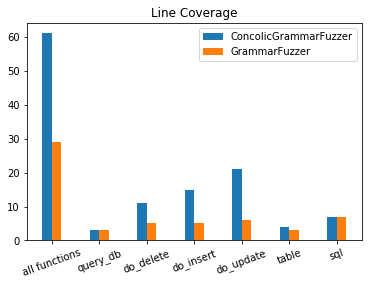



Branch Coverage                ConcolicGrammarFuzzer     GrammarFuzzer            
--------------------------------------------------------------------------------
all functions                  57                        25                       
query_db                       2                         2                        
do_delete                      10                        4                        
do_insert                      14                        4                        
do_update                      20                        5                        
table                          4                         3                        
sql                            7                         7                        


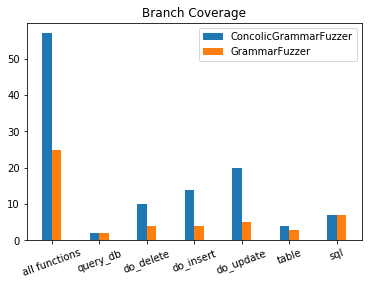



Exception Type                 ConcolicGrammarFuzzer     GrammarFuzzer            
--------------------------------------------------------------------------------
SQLException                   18757                     20000                    
TypeError                      646                       0                        


Number of Valid Inputs         ConcolicGrammarFuzzer     GrammarFuzzer            
--------------------------------------------------------------------------------
                               597                       0                        


Elapsed Time (s)               ConcolicGrammarFuzzer     GrammarFuzzer            
--------------------------------------------------------------------------------
                               2213.64                   521.6                    


In [14]:
config = {
    'target': TARGET_DEFAULT, 
    'grammar': GRAMMAR_DEFAULT, 
    'max_nonterminals': MAX_NONTERMINALS_DEFAULT, 
    'n_fuzz': 20000,
    'functions': FUNCTIONS_DEFAULT
}

result1, result2 = comperative_run(
    runner1=run_concolic_grammar_fuzzer,
    config1=config,
    runner2=run_grammar_fuzzer,
    config2=config
)

compare_results(result1, result2)

In [ ]:
seeds